## Importance of Bloch
Allows us to hardcore Kx and Ky vectors in an eigensolver, so these things should 100% work

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_w, structure
from eigenwell.src.constants import *
import scipy.sparse.linalg as la
from eigenwell.src.grid import *
from eigenwell.src import pml, pec_pmc
from eigenwell.src.constants import *

try:
    from pyMKL import pardisoSolver
    using_mkl = True
except:
    using_mkl = False
    
print(using_mkl)

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']


/Users/nathanzhao/src/eigenwell/src/grid.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(dL)==len(N) == 2, 'must specify 2 elem arr even for 1d sims')


True


In [2]:
N = np.array([160,440])
# plt.figure(figsize = (10,10))
# plt.spy(fd.Dyb, markersize = 2)
L = np.array([1e-6, 2e-6]);
Lx, Ly = L;
dL= L/N
print(L)
xrange = [-L[0]/2, L[0]/2]
yrange = [-L[1]/2, L[1]/2]

x = np.linspace(xrange[0], xrange[1], N[0])
y = np.linspace(yrange[0], yrange[1], N[1])

X,Y = np.meshgrid(x,y, indexing = 'ij');
print(dL)

[1.e-06 2.e-06]
[6.25000000e-09 4.54545455e-09]


[160 440]
[-5e-07, 5e-07] [-1e-06, 1e-06]
[6.25000000e-09 4.54545455e-09] [160 440] [1.e-06 2.e-06]
22214414.69079183 1e-06
(70400, 70400) (70400,)


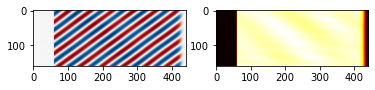

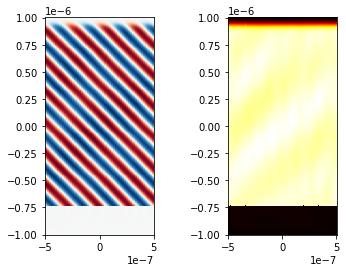

In [12]:
from scipy.sparse.linalg import spsolve as bslash
eps_r = np.ones(N)
wvlen = 0.2e-6;
Mz = np.zeros(N).astype('complex')

Npml = [0,40]
print(N)

degrees = np.pi/180;
ind_src = 60;
kx = (2*np.pi/wvlen)*np.sin(0);
ky = (2*np.pi/wvlen)*np.cos(0);
Kvec = [kx, ky]; 
xrange = [-Lx/2, Lx/2];
x_vec = np.linspace(xrange[0],xrange[1], N[0])

theta = 45*degrees;
       
kx = (2*np.pi/wvlen)*np.sin(theta);
ky = (2*np.pi/wvlen)*np.cos(theta);


Mz[:, ind_src] = np.exp(-1j*(kx*x_vec)); #this sets kx = 0; or theta = 0;
Mz[:, ind_src-1] = Mz[:, ind_src]*np.exp(-1j*(ky * dL[1]) - 1j*np.pi);

M = np.prod(N)
b = np.reshape(Mz, (M,), order = 'F'); #(Mz.flatten());

omega = 2*np.pi*C0/wvlen;

pml_obj = pml.PML(N,Npml, omega);
#self.Sxf, self.Syf, self.Sxb, self.Syb
Sxf, Syf, Sxb, Syb = pml_obj.Soperators(xrange, yrange);
print(xrange, yrange)


print(dL,N, dL*N)
fd = FiniteDifferenceGrid(dL,N)
fd.make_derivatives()

print(kx, L[0])

Dxf = fd.createDws_bloch('x', 'f', k = kx, L = Lx)
Dyf = fd.createDws_bloch('y', 'f', k = 0, L = 0)
Dxb = fd.createDws_bloch('x', 'b', k = kx, L = Lx)
Dyb = fd.createDws_bloch('y', 'b', k = 0, L = 0)


Tep = sp.spdiags(eps_r.flatten(), 0, np.prod(N), np.prod(N))

A = (Sxf@fd.Dxf)@(Sxb@fd.Dxb) + (Syf@fd.Dyf)@(Syb@fd.Dyb) + omega**2*MU0*EPSILON0*Tep;
A = (Sxf@Dxf)@(Sxb@Dxb) + (Syf@Dyf)@(Syb@Dyb) + omega**2*MU0*EPSILON0*Tep;

print(A.shape, b.shape)
## spsolve
from scipy.sparse.linalg import splu
solver = splu(A);

x = solver.solve(b)
field = np.reshape(x, N, order = 'F')

plt.subplot(121)
plt.imshow(np.real(field), cmap = 'RdBu')
plt.subplot(122)
plt.imshow(np.abs(field), cmap = 'hot')
plt.show();

ax = plt.subplot(121)
plt.pcolormesh(X,Y, np.real(field), cmap = 'RdBu', shading = 'auto')
ax.set_aspect('equal')
ax = plt.subplot(122)
plt.pcolormesh(X,Y,np.abs(field), cmap = 'hot',shading = 'auto')
ax.set_aspect('equal')

plt.show();


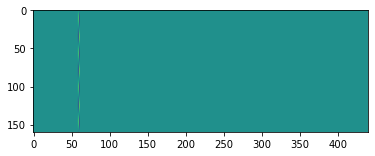

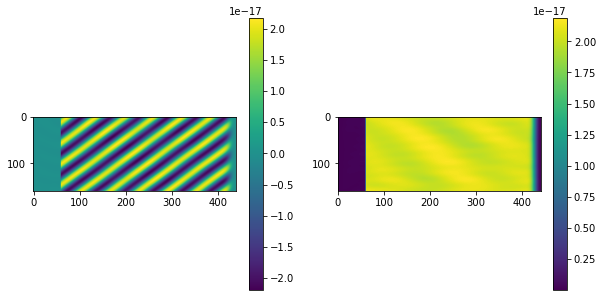

In [16]:
plt.imshow(np.real(Mz))
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.imshow(np.real(field))
plt.colorbar();
plt.subplot(122)
plt.imshow(np.abs(field))
plt.colorbar();
plt.show();

In [22]:
fd = FiniteDifferenceGrid([1,1],[3,3])
Dxf0 = fd.createDws('x','f')
Dxf0_bloch = fd.createDws_bloch('x','f', 0,0)
#print(Dxf0.toarray())
print((Dxf0_bloch.toarray()))
print()
print((Dxf0.toarray()))
print(kx*Lx)



[[-1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j -1.+0.j]]

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  1.]
 [ 0.  0.  